# Import modules

In [2]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
import random
import os
from shapely.geometry import Point

pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings("ignore")

try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-1]))
    kernel_is_loaded = True

# Seeding

In [16]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Old Mustard

## Importing Files and basic characteristic check

In [17]:
xlsx = pd.ExcelFile('data_files/new+old/old/crop_profiles.xlsx')
non_wheat = pd.read_excel(xlsx, 'crop')

display('raw:', non_wheat.head(3), non_wheat.shape)

non_wheat['Crop_Nam_1'] = non_wheat.Crop_Nam_1.apply(lambda row : row[2:] if row == '2 Mustard' else('Pulses' if row == 'pulses' else row)) # Some basic label cleaning

mustard = non_wheat[non_wheat.Crop_Nam_1 == 'Mustard']

mustard.drop(['FID', 'Crop_Nam_1', 'STATE_NAME'], axis=1, inplace=True)

mustard.columns = ['latitude', 'longitude', 'district', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 
                        'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f']

# New column values
new_columns = {'state_name': [['Madhya Pradesh'] * mustard.shape[0], 2],
               'taluka_name': [[np.nan] * mustard.shape[0], 4],
              'crop_name': [['Mustard'] * mustard.shape[0], 17]}

for cols in new_columns.keys():
    mustard.insert(new_columns[cols][1], cols, new_columns[cols][0])

display('cleaned: ', mustard.head(), mustard.shape)

'raw:'

,FID,lat,long,Crop_Nam_1,STATE_NAME,DISTRICT,Oct_2FN,Nov_1FN,Nov_2FN,Dec_1FN,Dec_2FN,Jan_1FN,Jan_2FN,Feb_1Fn,Feb_2Fn,Mar_1Fn,Mar_2Fn,Apr_1fn
0,66,26.275699,77.317284,2 Mustard,Madhya Pradesh,MORENA,117,130,183,186,183,188,184,184,165,131,165,180
1,819,26.235858,77.446783,2 Mustard,Madhya Pradesh,MORENA,121,151,190,191,188,186,189,187,168,138,149,171
2,1219,24.970808,75.246897,2 Mustard,Madhya Pradesh,NIMACH,142,174,178,181,180,177,163,129,135,138,145,171


(1581, 18)

'cleaned: '

,latitude,longitude,state_name,district,taluka_name,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,crop_name
0,26.275699,77.317284,Madhya Pradesh,MORENA,NaN,117,130,183,186,183,188,184,184,165,131,165,180,Mustard
1,26.235858,77.446783,Madhya Pradesh,MORENA,NaN,121,151,190,191,188,186,189,187,168,138,149,171,Mustard
2,24.970808,75.246897,Madhya Pradesh,NIMACH,NaN,142,174,178,181,180,177,163,129,135,138,145,171,Mustard
3,24.901777,75.255574,Madhya Pradesh,NIMACH,NaN,141,155,166,173,178,178,175,176,157,143,143,125,Mustard
4,24.901773,75.255630,Madhya Pradesh,NIMACH,NaN,141,155,166,173,178,178,175,176,157,143,143,125,Mustard


(1366, 18)

## Data cleaning and EDA

In [18]:
outliers = mustard[mustard.loc[:,'oct_2f':'nov_2f'].apply(lambda row:any((i == 1)|(i == 0) for i in row), axis=1)]

# Rows which have 0s or 1s in the 3 possible sowing periods for mustard are dropped
mustard.drop(outliers.index, inplace=True)

display(f'{outliers.shape[0]} dropped', mustard.loc[:,'oct_2f':'apr_1f'].describe().T)

'1 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,1365.0,128.738462,9.745878,109.0,122.0,127.0,134.0,175.0
nov_1f,1365.0,133.535531,15.670394,110.0,122.0,130.0,141.0,195.0
nov_2f,1365.0,162.583883,16.038481,120.0,151.0,166.0,175.0,194.0
dec_1f,1365.0,178.643223,8.872560,139.0,174.0,181.0,185.0,200.0
dec_2f,1365.0,181.142857,6.129417,153.0,178.0,182.0,185.0,200.0
jan_1f,1365.0,170.808791,37.724471,1.0,173.0,181.0,184.0,200.0
jan_2f,1365.0,178.448352,7.752287,141.0,175.0,180.0,184.0,200.0
feb_1f,1365.0,174.762637,10.145102,121.0,171.0,177.0,181.0,196.0
feb_2f,1365.0,157.676190,16.872970,112.0,148.0,160.0,171.0,196.0
mar_1f,1365.0,136.283516,16.651845,79.0,124.0,132.0,149.0,181.0


In [19]:
def harvest_avg_impute(row):
    lst = deepcopy(row)
    hrvst_strt_idx = lst.index.get_loc('jan_2f')
    for i in range(len(lst.loc['jan_2f':'mar_2f'])):
        actual_idx = i + hrvst_strt_idx
        if (lst[actual_idx] == 1) or (lst[actual_idx] == 0):
            if lst[actual_idx-1] < 140:
                lst[actual_idx] = (lst[actual_idx-1] + lst[actual_idx+1])/2
    return lst

# Imputing the possible harvest fns with the average of its immediate neighbours
mustard = mustard.apply(harvest_avg_impute, axis=1)

new_outliers = mustard[mustard.loc[:,'jan_2f':'apr_1f'].apply(lambda row:any((i == 1)|(i == 0) for i in row), axis=1)]
outliers = pd.concat([outliers, new_outliers])

# if 0s and 1s still exit in the possible harvest periods, those rows are dropped
mustard.drop(new_outliers.index, inplace=True)

display(f'{new_outliers.shape[0]} dropped', mustard.loc[:,'oct_2f':'apr_1f'].describe().T)

'53 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,1312.0,128.505335,9.458406,109.0,121.75,127.0,134.0,164.0
nov_1f,1312.0,133.733994,15.724511,110.0,122.00,130.0,141.0,195.0
nov_2f,1312.0,163.211890,15.800074,120.0,153.00,166.0,175.0,194.0
dec_1f,1312.0,179.238567,8.131937,139.0,175.00,181.0,185.0,200.0
dec_2f,1312.0,181.516006,5.642520,157.0,179.00,182.0,185.0,200.0
jan_1f,1312.0,170.770579,38.442761,1.0,173.00,181.0,184.0,200.0
jan_2f,1312.0,178.782012,7.459612,146.0,175.00,180.0,184.0,200.0
feb_1f,1312.0,175.137957,9.849904,121.0,172.00,177.0,181.0,196.0
feb_2f,1312.0,158.009909,16.676371,112.0,148.00,160.0,171.0,192.0
mar_1f,1312.0,136.551829,16.416269,89.0,124.00,132.0,149.0,181.0


<Axes: >

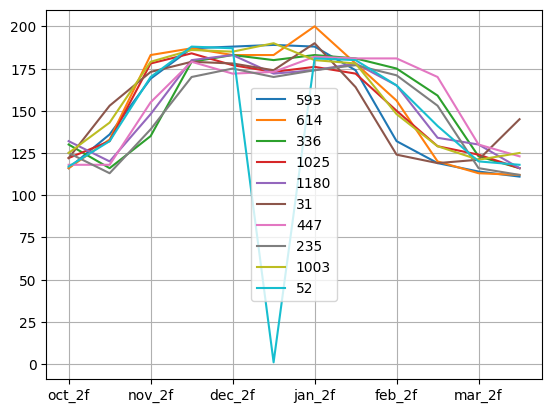

In [20]:
# We can see NDVI drops in jan_1f (This Fn can neither be a sowing period nor harvest period)
# This is due to cloud interfering with the reading

mustard.loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot()

In [21]:
def dip_impute(row):
    lst = deepcopy(row)
    act_strt_idx = lst.index.get_loc('dec_1f')
    for i in range(len(lst.loc['dec_1f':'jan_1f'])):
        actual_idx = i + act_strt_idx
        if (lst[actual_idx-1] - lst[actual_idx]) >= 20:
            lst[actual_idx] = (lst[actual_idx-1] + lst[actual_idx+1])/2
    return lst

# Imputing the dec_1f, dec_2f and jan_1f fornights with the averages if the dip is not less than 30 from the adjs 
mustard = mustard.apply(dip_impute, axis=1)

mustard.loc[:,'oct_2f':'apr_1f'].describe().T

,count,mean,std,min,25%,50%,75%,max
oct_2f,1312.0,128.505335,9.458406,109.0,121.75,127.0,134.0,164.0
nov_1f,1312.0,133.733994,15.724511,110.0,122.00,130.0,141.0,195.0
nov_2f,1312.0,163.211890,15.800074,120.0,153.00,166.0,175.0,194.0
dec_1f,1312.0,179.238567,8.131937,139.0,175.00,181.0,185.0,200.0
dec_2f,1312.0,181.516006,5.642520,157.0,179.00,182.0,185.0,200.0
jan_1f,1312.0,179.533155,7.219127,149.0,175.00,181.0,184.0,200.0
jan_2f,1312.0,178.782012,7.459612,146.0,175.00,180.0,184.0,200.0
feb_1f,1312.0,175.137957,9.849904,121.0,172.00,177.0,181.0,196.0
feb_2f,1312.0,158.009909,16.676371,112.0,148.00,160.0,171.0,192.0
mar_1f,1312.0,136.551829,16.416269,89.0,124.00,132.0,149.0,181.0


<Axes: >

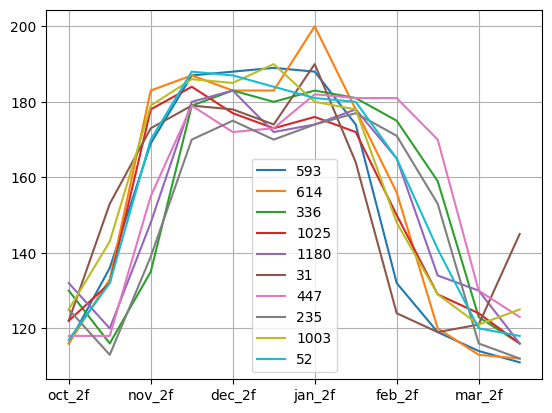

In [22]:
# Drops have been imputed

mustard.loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot()

__Determination of sowing period__

- Find the global minima of the time series containing scaled NDVI values ((NDVI *100)+100) from the first 5 fortnights.
- The chosen minima should have a value between 110-140.
- The successor of minima should have a slope of > 5.
- The fourth successive point from the minima should have a positive slope w.r.t the successor.
- If the minima doesn't satisfy the above criteria, consider the successive NDVI as the new probable sowing period and repeat the process.


In [23]:
# Sowing period determination

threshold = 5

def sowing_period(row):
    sowing_periods = row.loc['oct_2f':'dec_2f'].index
    sowing_periods_NDVI = row.loc['oct_2f':'dec_2f']
    minima = np.argmin(sowing_periods_NDVI)
    ndvi_values = row.loc['oct_2f':'apr_1f']
    i = minima
    while i < len(sowing_periods):
#         print(ndvi_values[idx])
        if ndvi_values[i] in set(np.arange(110, 141)):
            if (ndvi_values[i+1] - ndvi_values[i]) > threshold:
                if ((ndvi_values[i+1] - ndvi_values[i+4]) < 30):
                    return sowing_periods[i]
        i += 1
    return 'Unknown'

mustard['sowing_period'] = mustard.apply(sowing_period, axis=1)
mustard['sowing_year'] = [2022] * mustard.shape[0]

mustard.sowing_period.value_counts()

sowing_period
nov_1f     713
oct_2f     541
Unknown     41
nov_2f      17
Name: count, dtype: int64

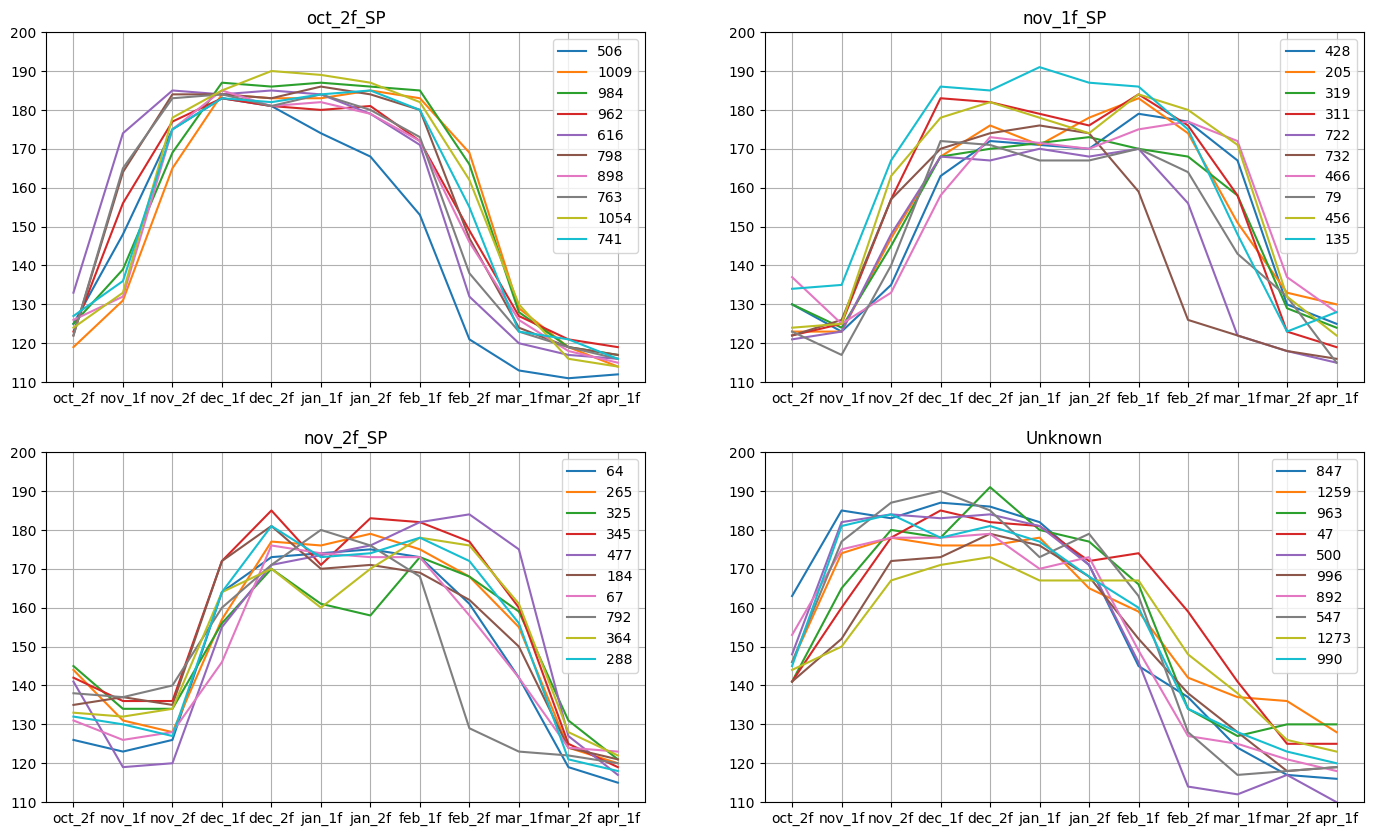

In [24]:
plt.rcParams['axes.grid'] = True

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,10))

plt.setp(axes,  xticks = np.arange(0,12,1), xticklabels = mustard.loc[:,'oct_2f':'apr_1f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200])

mustard[mustard.sowing_period == 'oct_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot(ax=axes[0,0],
                                                                                         title='oct_2f_SP')
mustard[mustard.sowing_period == 'nov_1f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot(ax=axes[0,1],
                                                                                         title='nov_1f_SP')
mustard[mustard.sowing_period == 'nov_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot(ax=axes[1,0],
                                                                                         title='nov_2f_SP')
mustard[mustard.sowing_period == 'Unknown'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot(ax=axes[1,1],
                                                                                         title='Unknown')

plt.show()

In [25]:
new_outliers = mustard[mustard.sowing_period == 'Unknown']
outliers = pd.concat([outliers, new_outliers])

# Dropping the Unknown sp labels
mustard.drop(new_outliers.index, inplace=True)

display(f'{new_outliers.shape[0]} dropped', mustard.loc[:,'oct_2f':'apr_1f'].describe().T)

'41 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,1271.0,127.974036,9.077884,109.0,121.0,126.0,133.0,164.0
nov_1f,1271.0,132.726987,14.714187,110.0,122.0,129.0,139.0,195.0
nov_2f,1271.0,162.826908,15.839299,120.0,153.0,166.0,174.0,194.0
dec_1f,1271.0,179.233674,8.205798,139.0,175.0,181.0,185.0,200.0
dec_2f,1271.0,181.571204,5.661954,157.0,179.0,182.0,185.0,200.0
jan_1f,1271.0,179.641227,7.226695,149.0,175.0,181.0,184.0,200.0
jan_2f,1271.0,179.092840,7.250362,146.0,175.0,181.0,184.0,200.0
feb_1f,1271.0,175.780488,8.771363,127.0,172.0,178.0,181.0,196.0
feb_2f,1271.0,158.609756,16.317095,112.0,149.0,161.0,171.0,192.0
mar_1f,1271.0,136.750590,16.472452,89.0,124.0,133.0,150.0,181.0


__Determination of Harvest__

- Needs sowing period to determine harvest period.
- First fortnight value under 140 after Six fortnights or 3 months from the sowing period will be the first fortnight after harvest.

In [26]:
# Getting the harvest_period fortnight labels

def harvest_period(row):
    sowing_period_idx = row.index.get_loc(row['sowing_period'])
    i = sowing_period_idx + 6
    while i < len(row.loc[:'apr_1f']):
        if row[i] < 140:
            return row.index[i-1]
        i += 1
    return 'Unknown'

mustard['harvest_period'] = mustard.apply(harvest_period, axis=1)
mustard['harvest_year'] = [2023] * mustard.shape[0]

mustard.harvest_period.value_counts()

harvest_period
feb_2f     609
mar_1f     449
feb_1f     175
mar_2f      23
jan_2f      10
Unknown      5
Name: count, dtype: int64

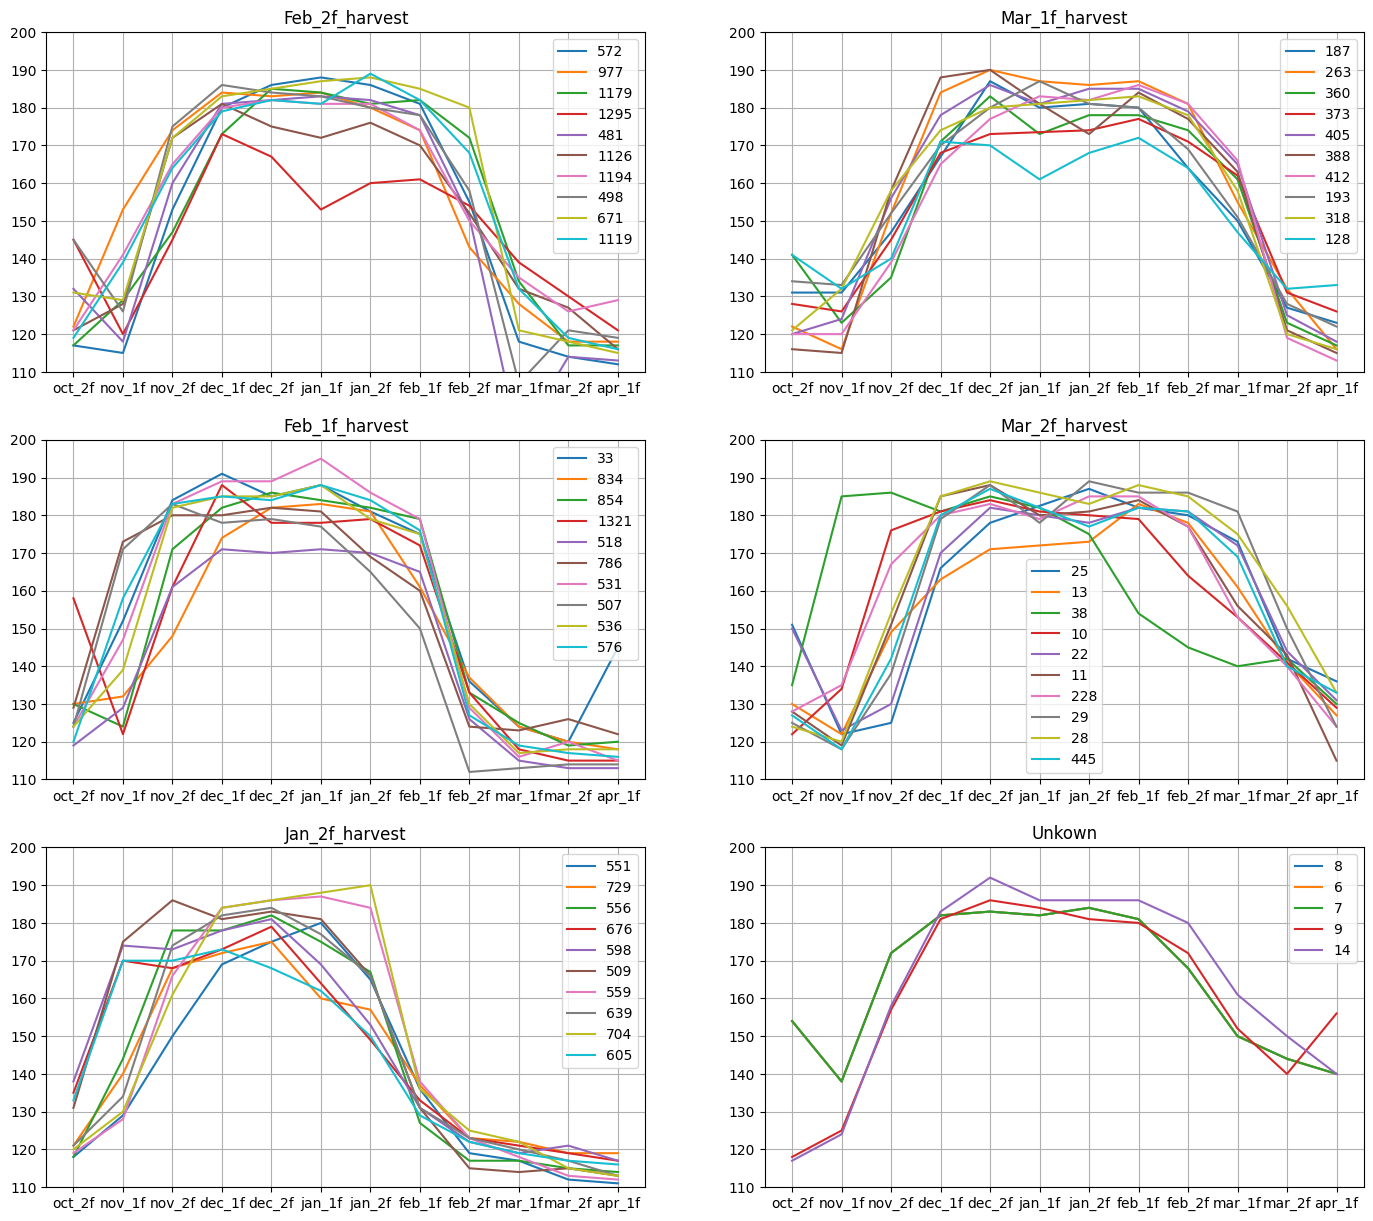

In [27]:
plt.rcParams['axes.grid'] = True

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(17,15))

plt.setp(axes,  xticks = np.arange(0,12,1), xticklabels = mustard.loc[:,'oct_2f':'apr_1f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200])

mustard[mustard.harvest_period == 'feb_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[0,0],
                                                                                         title='Feb_2f_harvest')
mustard[mustard.harvest_period == 'mar_1f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[0,1],
                                                                                         title='Mar_1f_harvest')
mustard[mustard.harvest_period == 'feb_1f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[1,0],
                                                                                         title='Feb_1f_harvest')
mustard[mustard.harvest_period == 'mar_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[1,1],
                                                                                         title='Mar_2f_harvest')
mustard[mustard.harvest_period == 'jan_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[2,0],
                                                                                         title='Jan_2f_harvest')
mustard[mustard.harvest_period == 'Unknown'].loc[:,'oct_2f':'apr_1f'].sample(5, random_state=190).T.plot(ax=axes[2,1],
                                                                                         title='Unkown')

plt.show()

In [28]:
new_outliers = mustard[mustard.harvest_period == 'Unknown']
outliers = pd.concat([outliers, new_outliers])

# Dropping the Unknown harvest labels
mustard.drop(new_outliers.index, inplace=True)

display(f'{new_outliers.shape[0]} dropped', mustard.loc[:,'oct_2f':'apr_1f'].describe().T)

'5 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,1266.0,127.928910,8.997303,109.0,121.0,126.0,133.0,164.0
nov_1f,1266.0,132.727488,14.737358,110.0,122.0,129.0,139.0,195.0
nov_2f,1266.0,162.813586,15.862851,120.0,153.0,166.0,174.0,194.0
dec_1f,1266.0,179.222749,8.220056,139.0,175.0,181.0,185.0,200.0
dec_2f,1266.0,181.556082,5.663734,157.0,179.0,182.0,185.0,200.0
jan_1f,1266.0,179.627172,7.236793,149.0,175.0,181.0,184.0,200.0
jan_2f,1266.0,179.074250,7.257926,146.0,175.0,181.0,184.0,200.0
feb_1f,1266.0,175.756714,8.779471,127.0,172.0,178.0,181.0,196.0
feb_2f,1266.0,158.560032,16.327429,112.0,149.0,161.0,171.0,192.0
mar_1f,1266.0,136.687994,16.472561,89.0,124.0,132.5,149.0,181.0


In [29]:
## Checking if there are rows which have max of NDVI values less than 150 for all the values between sp and hp.

def less_than_150_drop(row):
    sp_loc = row.index.get_loc(row['sowing_period'])
    hp_loc = row.index.get_loc(row['harvest_period'])
    if max(row.iloc[sp_loc+1:hp_loc]) < 150:
        return False
    return True    

new_outliers = mustard[mustard.apply(less_than_150_drop, axis=1) == False]
outliers = pd.concat([outliers, new_outliers])

mustard = mustard.drop(new_outliers.index)

display(f'{new_outliers.shape[0]} dropped', mustard.loc[:,'oct_2f':'apr_1f'].describe().T)

'0 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,1266.0,127.928910,8.997303,109.0,121.0,126.0,133.0,164.0
nov_1f,1266.0,132.727488,14.737358,110.0,122.0,129.0,139.0,195.0
nov_2f,1266.0,162.813586,15.862851,120.0,153.0,166.0,174.0,194.0
dec_1f,1266.0,179.222749,8.220056,139.0,175.0,181.0,185.0,200.0
dec_2f,1266.0,181.556082,5.663734,157.0,179.0,182.0,185.0,200.0
jan_1f,1266.0,179.627172,7.236793,149.0,175.0,181.0,184.0,200.0
jan_2f,1266.0,179.074250,7.257926,146.0,175.0,181.0,184.0,200.0
feb_1f,1266.0,175.756714,8.779471,127.0,172.0,178.0,181.0,196.0
feb_2f,1266.0,158.560032,16.327429,112.0,149.0,161.0,171.0,192.0
mar_1f,1266.0,136.687994,16.472561,89.0,124.0,132.5,149.0,181.0


# Pipeline to preprocess data

In [30]:
def data_preprocess(data):
    outliers = data[data.loc[:,'oct_2f':'nov_2f'].apply(lambda row:any((i == 1)|(i == 0) for i in row), axis=1)]

    # Rows which have 0s or 1s in the 3 possible sowing periods for data are dropped
    data.drop(outliers.index, inplace=True)

    # Imputing the possible harvest fns with the average of its immediate neighbours
    data = data.apply(harvest_avg_impute, axis=1)
    
    new_outliers = data[data.loc[:,'jan_2f':'apr_1f'].apply(lambda row:any((i == 1)|(i == 0) for i in row), axis=1)]
    outliers = pd.concat([outliers, new_outliers])
    
    # if 0s and 1s still exit in the possible harvest periods, those rows are dropped
    data.drop(new_outliers.index, inplace=True)

    # Imputing the dec_1f, dec_2f and jan_1f fornights with the averages if the dip is not less than 30 from the adjs 
    data = data.apply(dip_impute, axis=1)

    # Sowing period determination
    data['sowing_period'] = data.apply(sowing_period, axis=1)
    data['sowing_year'] = [2022] * data.shape[0]
    
    new_outliers = data[data.sowing_period == 'Unknown']
    outliers = pd.concat([outliers, new_outliers])
    
    # Dropping the Unknown sp labels
    data.drop(new_outliers.index, inplace=True)

    data['harvest_period'] = data.apply(harvest_period, axis=1)
    data['harvest_year'] = [2023] * data.shape[0]

    new_outliers = data[data.harvest_period == 'Unknown']
    outliers = pd.concat([outliers, new_outliers])
    
    # Dropping the Unknown harvest labels
    data.drop(new_outliers.index, inplace=True)

    new_outliers = data[data.apply(less_than_150_drop, axis=1) == False]
    outliers = pd.concat([outliers, new_outliers])
    
    # Dropping the rows which have max of NDVI values less than 150 for all the values between sp and hp.
    data = data.drop(new_outliers.index)

    display(data.head(3), data.shape)

    return data, outliers

# New Mustard

In [31]:
def new_GT_initial_preprocess():
    
    files = np.array(glob(r'data_files/new+old/new/Point/**/*.xlsx', recursive=True))

    series = pd.Series(pd.read_excel(files[0]).columns)
    ndvi_cols = list(series[series.apply(lambda row : True if 'FN' in row else False)])
    
    std_columns = ['latitude', 'longitude', 'state_name', 'district', 
                        'taluka_name', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 
                        'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 
                        'mar_2f', 'apr_1f', 'crop_name']
    
    mustard = pd.DataFrame(columns = std_columns)

    for file in files:
        raw = pd.read_excel(file)
        mustard_sample = pd.DataFrame(columns = std_columns)
        mustard_sample['longitude'] = raw['geometry'].apply(lambda row:float(row.split(' ')[1][1:])/10000)
        mustard_sample['latitude'] = raw['geometry'].apply(lambda row:float(row.split(' ')[-1][:-1])/100000)
        mustard_sample[['oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f']] = raw[ndvi_cols[1:13]]
        if 'Wheat' not in file:
            if 'Shivpuri' in file:
                mustard_sample['taluka_name'] = ['SHIVPURI'] * mustard_sample.shape[0]
            else:
                mustard_sample['taluka_name'] = ['KARERA'] * mustard_sample.shape[0]
            mustard = pd.concat([mustard, mustard_sample],ignore_index=True)
            
    mustard.loc[:,'oct_2f':'apr_1f'] = mustard.loc[:,'oct_2f':'apr_1f'].apply(lambda row:round(row*100+100))
    mustard['district']=['SHIVPURI']*mustard.shape[0]
    mustard['state_name']=['Madhya Pradesh']*mustard.shape[0]
    mustard['crop_name'] =  ['Mustard'] * mustard.shape[0]
    
    return mustard

# Initial preprocessing of mustard
new_mustard= new_GT_initial_preprocess()

display(new_mustard.head(3), new_mustard.shape)

,latitude,longitude,state_name,district,taluka_name,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,crop_name
0,28.283603,82.077138,Madhya Pradesh,SHIVPURI,KARERA,130.0,143.0,177.0,184.0,179.0,175.0,176.0,172.0,160.0,142.0,135.0,132.0,Mustard
1,28.259578,82.785553,Madhya Pradesh,SHIVPURI,KARERA,127.0,128.0,155.0,177.0,181.0,174.0,174.0,173.0,159.0,135.0,120.0,117.0,Mustard
2,28.259031,82.792574,Madhya Pradesh,SHIVPURI,KARERA,126.0,132.0,162.0,175.0,176.0,174.0,174.0,168.0,148.0,126.0,120.0,117.0,Mustard


(809, 18)

In [32]:
# Preprocessing new_mustard
new_mustard, new_outliers = data_preprocess(new_mustard)

,latitude,longitude,state_name,district,taluka_name,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,...,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,crop_name,sowing_period,sowing_year,harvest_period,harvest_year
0,28.283603,82.077138,Madhya Pradesh,SHIVPURI,KARERA,130.0,143.0,177.0,184.0,179.0,...,172.0,160.0,142.0,135.0,132.0,Mustard,oct_2f,2022,mar_1f,2023
1,28.259578,82.785553,Madhya Pradesh,SHIVPURI,KARERA,127.0,128.0,155.0,177.0,181.0,...,173.0,159.0,135.0,120.0,117.0,Mustard,nov_1f,2022,feb_2f,2023
2,28.259031,82.792574,Madhya Pradesh,SHIVPURI,KARERA,126.0,132.0,162.0,175.0,176.0,...,168.0,148.0,126.0,120.0,117.0,Mustard,oct_2f,2022,feb_2f,2023


(708, 22)

# File Export

In [156]:
mustard.to_csv(r'data_files/data_share/preprocessed_mustard.csv', index=False)
new_mustard.to_csv(r'data_files/data_share/preprocessed_new_mustard.csv', index=False)

# File Export for Data Ingestion

In [157]:
mustard = pd.concat([mustard, new_mustard], ignore_index=True)

In [158]:
ingest_order = ['latitude', 'longitude', 'state_name', 'district', 'taluka_name', 'sowing_period', 'crop_name',
                'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f', 'oct_2f', 'nov_1f', 
                'nov_2f', 'dec_1f', 'dec_2f', 'sowing_year', 'harvest_year', 'harvest_period']

mustard = mustard[ingest_order]

In [159]:
new_columns = ['apr_2f', 'may_1f', 'may_2f', 'jun_1f', 'jun_2f', 'jul_1f', 'jul_2f', 'aug_1f', 'aug_2f', 
               'sep_1f', 'sep_2f', 'oct_1f']

i = 12
for cols in new_columns:
    mustard.insert(i, cols, [np.nan]*mustard.shape[0])
    i += 1
    
mustard.head(3)

,latitude,longitude,state_name,district,taluka_name,sowing_period,crop_name,jan_1f,jan_2f,feb_1f,...,mar_2f,apr_1f,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,sowing_year,harvest_year,harvest_period
0,26.275699,77.317284,Madhya Pradesh,MORENA,NaN,oct_2f,Mustard,188.0,184.0,184.0,...,165.0,180.0,117.0,130.0,183.0,186.0,183.0,2022,2023,feb_2f
1,26.235858,77.446783,Madhya Pradesh,MORENA,NaN,oct_2f,Mustard,186.0,189.0,187.0,...,149.0,171.0,121.0,151.0,190.0,191.0,188.0,2022,2023,feb_2f
2,26.162953,77.120647,Madhya Pradesh,SHEOPUR,NaN,nov_1f,Mustard,186.0,200.0,182.0,...,134.0,147.0,126.0,128.0,176.0,178.0,183.0,2022,2023,mar_1f


In [160]:
NDVI_bands = ['jan_1f','jan_2f', 'feb_1f', 'feb_2f', 'mar_1f','mar_2f', 'apr_1f', 'apr_2f', 'may_1f','may_2f', 
              'jun_1f', 'jun_2f', 'jul_1f', 'jul_2f', 'aug_1f', 'aug_2f', 'sep_1f', 'sep_2f', 'oct_1f', 'oct_2f', 
              'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f']

mustard = mustard.melt(id_vars =['latitude', 'longitude', 'state_name', 'district', 'taluka_name', 'sowing_period', 
                             'sowing_year', 'harvest_period', 'harvest_year', 'crop_name'],
                               value_vars = NDVI_bands, var_name = 'ndvi_capture_period', value_name='ndvi_value')

mustard = mustard[['latitude', 'longitude', 'state_name', 'district', 'taluka_name','sowing_period',
              'crop_name', 'ndvi_capture_period', 'ndvi_value', 'sowing_year', 'harvest_year', 'harvest_period']]

mustard.head(3)

,latitude,longitude,state_name,district,taluka_name,sowing_period,crop_name,ndvi_capture_period,ndvi_value,sowing_year,harvest_year,harvest_period
0,26.275699,77.317284,Madhya Pradesh,MORENA,NaN,oct_2f,Mustard,jan_1f,188.0,2022,2023,feb_2f
1,26.235858,77.446783,Madhya Pradesh,MORENA,NaN,oct_2f,Mustard,jan_1f,186.0,2022,2023,feb_2f
2,26.162953,77.120647,Madhya Pradesh,SHEOPUR,NaN,nov_1f,Mustard,jan_1f,186.0,2022,2023,mar_1f


In [161]:
mustard.insert(6, 'year', [np.nan] * mustard.shape[0])
mustard.insert(10, 'location', [np.nan] * mustard.shape[0])
mustard.insert(11, 'ndvi_capture_date', [np.nan] * mustard.shape[0])
mustard.insert(12, 'interval_range', [np.nan] * mustard.shape[0])
mustard.insert(14, 'sowing_date', [np.nan] * mustard.shape[0])

mustard.head(3)

,latitude,longitude,state_name,district,taluka_name,sowing_period,year,crop_name,ndvi_capture_period,ndvi_value,location,ndvi_capture_date,interval_range,sowing_year,sowing_date,harvest_year,harvest_period
0,26.275699,77.317284,Madhya Pradesh,MORENA,NaN,oct_2f,NaN,Mustard,jan_1f,188.0,NaN,NaN,NaN,2022,NaN,2023,feb_2f
1,26.235858,77.446783,Madhya Pradesh,MORENA,NaN,oct_2f,NaN,Mustard,jan_1f,186.0,NaN,NaN,NaN,2022,NaN,2023,feb_2f
2,26.162953,77.120647,Madhya Pradesh,SHEOPUR,NaN,nov_1f,NaN,Mustard,jan_1f,186.0,NaN,NaN,NaN,2022,NaN,2023,mar_1f


In [162]:
def find_tehsil(coordinates, shape_file_path):
    # Create a list of Point objects from the coordinates
    points = [Point(lon, lat) for lat, lon in coordinates]

    # Create a GeoDataFrame with the location points
    gdf = gp.GeoDataFrame({"location": points}, geometry='location')
    shp_file = gp.read_file(shape_file_path)
    
    gdf.crs = "epsg:4326"
    gdf.to_crs("WGS84", inplace=True)
    
    shp_file.to_crs("WGS84", inplace=True)
    
    latlong_with_talukas = gp.sjoin(gdf, shp_file, how='left', predicate='within')
    # # Identify the values that are not mapped (don't have matches)
    # not_mapped = gdf[~gdf.index.isin(latlong_with_talukas.index)]
    # print(not_mapped)
    
    upper_case_talukas = latlong_with_talukas['Tehsil_1'].apply(lambda taluka: str(taluka).upper()).to_numpy()
    return upper_case_talukas

mustard['taluka_name'] = find_tehsil(mustard[['latitude', 'longitude']].values, 'data_files/sub_district/SUBDISTRICT_BOUNDARY.shp')
mustard['taluka_name'] = mustard['taluka_name'].apply(lambda taluka: np.nan if taluka == 'NAN' else taluka)

In [163]:
mustard = mustard.loc[mustard['taluka_name'].dropna().index]

In [164]:
mustard.to_csv(r'data_files/data_share/mustard_for_ingestion.csv', index=False)

In [3]:
np.array(glob(r'data_files/new+old/new/Polygon/**/*.xlsx', recursive=True))

array(['data_files/new+old/new/Polygon/Karera_Teh_Must_100_80.xlsx',
       'data_files/new+old/new/Polygon/Karera_Teh_Wheat.xlsx',
       'data_files/new+old/new/Polygon/Shivpuri_Teh_Must_100_100.xlsx',
       'data_files/new+old/new/Polygon/Shivpuri_Teh_Wheat.xlsx'],
      dtype='<U61')

In [27]:
coordinates = pd.read_excel('data_files/new+old/new/Polygon/Karera_Teh_Must_100_80.xlsx')[pd.read_excel('data_files/new+old/new/Polygon/Karera_Teh_Must_100_80.xlsx')['villagee'] == 'Patha']['geometry'].values[0][10:-2].split(', ')

In [30]:
pd.Series(coordinates).apply(lambda row:row.split(' '))

0          [795695.2799000004, 2824596.9496]
1          [795707.1018000003, 2824579.9342]
2          [795712.0602000002, 2824561.9912]
3          [795705.9104000004, 2824563.5954]
4    [795683.9682999998, 2824575.8188000005]
5    [795674.6074000001, 2824578.4858999997]
6          [795671.6682000002, 2824591.8104]
7    [795671.2302000001, 2824606.0132999998]
8          [795695.2799000004, 2824596.9496]
dtype: object